In [1]:
import numpy as np
import pandas as pd
import locale
import time
import matplotlib.pyplot as plt



locale.setlocale(locale.LC_TIME, "de_DE")

%store -r columnNames

#pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
# pd.set_option('display.max_colwidth', None)  # or 199

# pd.describe_option('display')

plt.close("all")

# Get Results

In [2]:
surveyData=pd.read_csv('justCompletedAttempts.csv', sep=';')
print("Anzahl an kompletten Daten:", len(surveyData))

# Add extra fields for comparison
surveyData['duration-date-based'] = surveyData.apply(lambda row: pd.to_datetime(row['date-last'])-pd.to_datetime(row['date-start']), axis=1)
surveyData['duration-date-based-in-seconds'] = surveyData.apply(lambda row: row['duration-date-based'].total_seconds(), axis=1)
surveyData['duration-delta-all-vs-start-end'] = surveyData.apply(lambda row: row['duration-over-all']-row['duration-date-based-in-seconds'], axis=1)

# Build groups depending on what viz participant had to solve first

listFirstParticipants=surveyData[surveyData['list-question-number']==6]
chordFirstParticipants=surveyData[surveyData['chord-question-number']==6]
mapFirstParticipants=surveyData[surveyData['map-question-number']==6]

Anzahl an kompletten Daten: 203


## Socio-Demographic Data

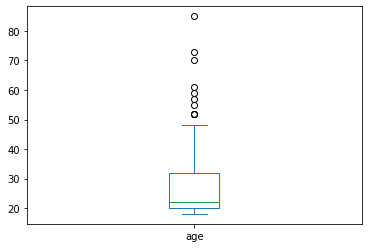

In [4]:
df = surveyData['age']

df.plot.box();